In [1]:
import pandas as pd
import numpy as np

import re
import string
import hashlib
import nltk
import glob
import errno
import csv
from os import listdir
import os
from os.path import isfile
from os.path import join
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


from sklearn import metrics
from nltk.stem.porter import PorterStemmer

In [2]:
df = pd.read_excel("map.xlsx")

In [3]:
df.head(5)
df.columns

Index(['Sector', 'Unnamed: 1', 'Sub-Industry', 'Unnamed: 3'], dtype='object')

In [4]:
df =df.rename(columns={'Unnamed: 1' : 'Sector_name', })

In [5]:
df.drop(['Sector'],axis =1,inplace= True)

In [6]:
df.drop(['Sub-Industry'],axis =1,inplace= True)

In [7]:
df.columns

Index(['Sector_name', 'Unnamed: 3'], dtype='object')

In [8]:
df =df.rename(columns={'Unnamed: 3' : 'Sector_Description', })

In [9]:
df.columns

Index(['Sector_name', 'Sector_Description'], dtype='object')

In [10]:
df.head(5)

Sector_name                                 Sector_Description
0      Energy                                 Oil & Gas Drilling
1      Energy  Drilling contractors or owners of drilling rig...
2      Energy                     Oil & Gas Equipment & Services
3      Energy  Manufacturers of equipment, including drilling...
4      Energy                               Integrated Oil & Gas

In [11]:
import re
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

df['text'] =df['Sector_Description']
df['text'] = df['text'].apply(lambda x:pre_process(x))

#show the first 'text'
df['text'][16]

'diversified chemicals'

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords



#load a set of stop words
stopwords=set(stopwords.words("english"))
#get the text column 
docs=df['text'].tolist()

#create a vocabulary of words, 
#ignore words that appear in 85% of documents, 
#eliminate stop words
cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
word_count_vector=cv.fit_transform(docs)

In [13]:
word_count_vector.shape

(330, 836)

In [14]:
cv=CountVectorizer(max_df=0.85,stop_words=stopwords,max_features=10000)
word_count_vector=cv.fit_transform(docs)
word_count_vector.shape

(330, 836)

In [15]:
list(cv.vocabulary_.keys())[:10]

['oil',
 'gas',
 'drilling',
 'contractors',
 'owners',
 'rigs',
 'contract',
 'services',
 'wells',
 'equipment']

In [16]:
list(cv.get_feature_names())[:20]

['access',
 'accessories',
 'acquisition',
 'acquisitions',
 'across',
 'activities',
 'activity',
 'added',
 'addition',
 'additives',
 'adhesives',
 'advanced',
 'advertisements',
 'advertising',
 'advisory',
 'aerospace',
 'african',
 'agencies',
 'agency',
 'agents']

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [18]:
#tfidf_transformer.idf_

In [19]:
df['text'] =  df['Sector_Description']

df['text'] =df['text'].apply(lambda x:pre_process(x))

docs_test=df['text'].tolist()

In [20]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [21]:


# you only needs to do this once
feature_names=cv.get_feature_names()

# get the document that we want to extract keywords from
doc=docs_test[1]

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names,sorted_items,10)

# now print the results
print("\n=====Title=====")
print(docs_test[0])
print("\n===Keywords===")
for k in keywords:
    print(k,keywords[k])


=====Title=====
oil gas drilling

===Keywords===
drilling 0.798
wells 0.28
rigs 0.28
contractors 0.28
contract 0.28
owners 0.18
services 0.128


In [22]:
#docs_test

In [23]:
# put the common code into several methods
def get_keywords(idx):

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([docs_test[idx]]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,10)
    
    return keywords

def print_results(idx,keywords):
    # now print the results
    print("\n=====Title=====")
    print(docs_test[idx])
    print("\n===Keywords===")
    for k in keywords:
        print(k,keywords[k])

In [24]:
idx=329
keywords=get_keywords(idx)
print_results(idx,keywords)


=====Title=====
real estate service providers such as real estate agents brokers real estate appraisers 

===Keywords===
real 0.597
estate 0.597
appraisers 0.27
brokers 0.252
agents 0.252
service 0.24
providers 0.171


In [25]:
idx=16
keywords=get_keywords(idx)
print(docs_test[16])
print_results(idx,keywords)


diversified chemicals

=====Title=====
diversified chemicals

===Keywords===
chemicals 0.771
diversified 0.636


In [26]:
dict_new = {}
idx =1
while(idx<320):
    keywords=get_keywords(idx)
    print(docs_test[idx])
    print(keywords)
    dict_new.update(keywords)
    idx=idx+1


    

drilling contractors or owners of drilling rigs that contract their services for drilling wells
{'drilling': 0.798, 'wells': 0.28, 'rigs': 0.28, 'contractors': 0.28, 'contract': 0.28, 'owners': 0.18, 'services': 0.128}
oil gas equipment services
{'oil': 0.589, 'gas': 0.551, 'equipment': 0.468, 'services': 0.361}
manufacturers of equipment including drilling rigs and equipment and providers of supplies and services to companies involved in the drilling evaluation and completion of oil and gas wells 
{'drilling': 0.525, 'equipment': 0.327, 'evaluation': 0.296, 'completion': 0.296, 'wells': 0.277, 'rigs': 0.277, 'supplies': 0.229, 'involved': 0.223, 'oil': 0.205, 'gas': 0.192}
integrated oil gas
{'integrated': 0.653, 'oil': 0.553, 'gas': 0.518}
integrated oil companies engaged in the exploration production of oil and gas as well as at least one other significant activity in either refining marketing and transportation or chemicals 
{'oil': 0.403, 'one': 0.271, 'least': 0.271, 'well': 0.25

providers of consumer finance services including personal credit credit cards lease financing travel related money services and pawn shops excludes mortgage lenders classified in the thrifts mortgage finance sub industry 
{'credit': 0.439, 'mortgage': 0.34, 'finance': 0.34, 'shops': 0.22, 'pawn': 0.22, 'money': 0.22, 'lenders': 0.22, 'lease': 0.22, 'travel': 0.205, 'financing': 0.205}
asset management custody banks
{'custody': 0.566, 'asset': 0.566, 'banks': 0.452, 'management': 0.393}
financial institutions primarily engaged in investment management and or related custody and securities fee based services includes companies operating mutual funds closed end funds and unit investment trusts excludes banks and other financial institutions primarily involved in commercial lending investment banking brokerage and other specialized financial activities 
{'investment': 0.419, 'financial': 0.372, 'funds': 0.351, 'institutions': 0.288, 'primarily': 0.18, 'unit': 0.175, 'mutual': 0.175, 'fee':

In [27]:
#dict_new

In [41]:
#dict_new.keys()

In [30]:
#import json

#with open("keywordsnew.txt", "w") as f:
#    json.dump(dict, f)

In [43]:
#dict_new.items()

In [27]:
temp = []
dictList = []

#My attempt:
for key, value in dict_new.items():
    aKey = key
    aValue = value
    temp.append(aKey)
    temp.append(aValue)
    dictList.append(temp) 
    aKey = ""
    aValue = ""

In [28]:
import re
import string
frequency = {}
dictword = dict_new.keys()



# DO not run system will hang

In [ ]:
import os
from os import listdir
from os.path import isfile, join

newspath = '/Users/varsha/GWU_SPRING2019/Topics in Big Data/Project/Code/Similarity/Weekly_news'

newsfiles = [f for f in listdir(newspath) if isfile(join(newspath, f))]

for file in newsfiles:
    filepath = newspath + "/" + file
    data = open(filepath,'r',encoding='utf-8')
    text = data.read()
    text_string = text.lower()




    for raw_str in dictword:
            pat = re.compile(raw_str)
            for w in text_string.split():
                if pat.match(w):
                    print ("Keywords:", raw_str, "with TextFileWords:", w)
                    count = frequency.get(w,0)
                    frequency[w] = count + 1
                    frequency_list = frequency.keys()
                    
                    
                    for w in frequency_list:
                        print(w, frequency[w])



In [29]:
document_text = open('/Users/varsha/GWU_SPRING2019/Topics in Big Data/Project/Code/Similarity/Weekly_news/00.txt', 'r')
text_string = document_text.read().lower()
for raw_str in dictword:
    pat = re.compile(raw_str)
    for w in text_string.split():
        if pat.match(w):
            print("--------------------------MATCH--------------------------")
            print ("Keywords:", raw_str, "with Text File Words:", w)
            count = frequency.get(w,0)
            frequency[w] = count + 1
            frequency_list = frequency.keys()
 
            for w in frequency_list:
                   print(w, frequency[w])
            
            

--------------------------MATCH--------------------------
Keywords: contract with Text File Words: contract
contract 1
--------------------------MATCH--------------------------
Keywords: oil with Text File Words: oil
contract 1
oil 1
--------------------------MATCH--------------------------
Keywords: gas with Text File Words: gas
contract 1
oil 1
gas 1
--------------------------MATCH--------------------------
Keywords: gas with Text File Words: gas
contract 1
oil 1
gas 2
--------------------------MATCH--------------------------
Keywords: gas with Text File Words: gas
contract 1
oil 1
gas 3
--------------------------MATCH--------------------------
Keywords: one with Text File Words: one
contract 1
oil 1
gas 3
one 1
--------------------------MATCH--------------------------
Keywords: one with Text File Words: one
contract 1
oil 1
gas 3
one 2
--------------------------MATCH--------------------------
Keywords: one with Text File Words: one
contract 1
oil 1
gas 3
one 3
----------------------

least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 9
southgate 1
--------------------------MATCH--------------------------
Keywords: south with Text File Words: south
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 10
southgate 1
--------------------------MATCH--------------------------
Keywords: south with Text File Words: south
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 1
--------------------------MATCH--------------------------
Keywords: south with Text File Words: southgate
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
--------------------------MATCH--------------------------
Keywords: african with Text File Words: africans
contract 1
oil 1
gas 

investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 3
--------------------------MATCH--------------------------
Keywords: protection with Text File Words: protection
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 4
--------------------------MATCH--------------------------
Keywords: protection with Text File Words: protection
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 5
---------------------

large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
--------------------------MATCH--------------------------
Keywords: video with Text File Words: video
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
--------------------------MATCH--------------------------
Keywords: tour with Text File Words: tourist
contract 1
oil 1
gas 3
one 9
least 5


game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 1
music 1
bookshop 2
tv 3
ordered 1
computer 2
--------------------------MATCH--------------------------
Keywords: supply with Text File Words: supply
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 1
music 1
bookshop 2
tv 3
ordered 1
computer 2
supply 1
--------------------------MATCH--------------------------
Keywords: supply with Text File Words: supply
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semicondu

one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 1
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 1
--------------------------MATCH--------------------------
Keywords: small with Text File Words: smaller
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8


roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 1
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financial 3
revenue 2
central 1
credit 1
--------------------------MATCH--------------------------
Keywords: money with Text File Words: money
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 1
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2

--------------------------MATCH--------------------------
Keywords: end with Text File Words: end
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 2
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financial 3
revenue 2
central 1
credit 1
money 2
united 4
unity 2
endorses 1
end 3
--------------------------MATCH--------------------------
Keywords: end with Text File Words: end
contract 1
oil 1
gas 3
one 9
least 5
powe

brokerage 1
lending 4
capitals 1
--------------------------MATCH--------------------------
Keywords: capital with Text File Words: capital
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 2
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financial 3
revenue 2
central 1
credit 1
money 2
united 4
unity 2
endorses 2
end 7
brokerage 1
lending 4
capitals 1
capital 1
--------------------------MATCH------------------------

airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 2
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financial 3
revenue 2
central 1
credit 1
money 2
united 4
unity 2
endorses 2
end 7
brokerage 1
lending 4
capitals 2
capital 6
purchase 1
service 4
--------------------------MATCH--------------------------
Keywords: service with Text File Words: service
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
au

eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financial 3
revenue 2
central 1
credit 1
money 2
united 4
unity 2
endorses 2
end 7
brokerage 1
lending 4
capitals 2
capital 6
purchase 1
service 6
back 5
infrastructure 1
test 1
--------------------------MATCH--------------------------
Keywords: test with Text File Words: test
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 4
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 2
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
sm

employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 2
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financial 3
revenue 2
central 1
credit 1
money 2
united 4
unity 2
endorses 2
end 7
brokerage 1
lending 4
capitals 2
capital 6
purchase 1
service 6
back 5
infrastructure 1
test 3
signal 2
highway 2
--------------------------MATCH--------------------------
Keywords: high with Text File Words: highway
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 8
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3

wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 2
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financial 3
revenue 2
central 1
credit 1
money 2
united 4
unity 2
endorses 2
end 7
brokerage 1
lending 4
capitals 2
capital 6
purchase 1
service 6
back 5
infrastructure 1
test 3
signal 2
highway 6
higher 2
highlights 1
network 2
telecommunication 1
--------------------------MATCH--------------------------
Keywords: telecommunication with Text File Words: telecommunication
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 8
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1

rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 2
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financial 3
revenue 2
central 1
credit 1
money 2
united 4
unity 2
endorses 2
end 7
brokerage 1
lending 4
capitals 2
capital 6
purchase 1
service 6
back 5
infrastructure 1
test 3
signal 2
highway 6
higher 2
highlights 1
network 2
telecommunication 2
gambling 2
search 3
peru 2
percent 2
persist 1
--------------------------MATCH--------------------------
Keywords: per with Text File Words: percent
contract 1
oil 1
gas 3
one 9
least 5
po

capital 6
purchase 1
service 6
back 5
infrastructure 1
test 3
signal 2
highway 6
higher 2
highlights 1
network 2
telecommunication 2
gambling 2
search 3
peru 3
percent 4
persist 2
pay 1
payment 3
utility 1
--------------------------MATCH--------------------------
Keywords: utility with Text File Words: utility
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1
semiconductor 8
subway 1
rockets 2
south 11
southgate 2
africans 1
african 2
invest 6
investors 1
defense 1
civilians 1
large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 2
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financia

large 1
heavy 3
stake 2
machinery 8
water 2
pollution 2
officer 1
office 4
security 7
protection 6
employment 2
human 3
airline 1
air 1
airliner 1
airport 2
passenger 1
landmark 4
vehicle 2
roadside 1
auto 4
lightning 1
motorcycle 2
three 2
home 2
game 3
wall 1
hand 1
video 1
tourist 6
closely 2
close 4
closed 2
music 1
bookshop 4
tv 3
ordered 1
computer 2
supply 2
market 3
caretaker 2
carey 3
healthily 1
eye 1
sector 2
nationalism 3
national 3
smaller 4
medium 3
financial 3
revenue 2
central 1
credit 1
money 2
united 4
unity 2
endorses 2
end 7
brokerage 1
lending 4
capitals 2
capital 6
purchase 1
service 6
back 5
infrastructure 1
test 3
signal 2
highway 6
higher 2
highlights 1
network 2
telecommunication 2
gambling 2
search 3
peru 3
percent 4
persist 2
pay 1
payment 3
utility 4
two 6
across 1
--------------------------MATCH--------------------------
Keywords: across with Text File Words: across
contract 1
oil 1
gas 3
one 9
least 5
power 7
coal 3
coalition 2
chemical 3
rangers 1
mine 1

In [42]:
word = open('/Users/varsha/GWU_SPRING2019/Topics in Big Data/Project/Code/Similarity/keywords_extracted/dict_Information Technology.txt','r')
wordnew = word.read().lower()                       
document_text = open('/Users/varsha/GWU_SPRING2019/Topics in Big Data/Project/Code/Similarity/Weekly_news/01.txt', 'r')
text_string = document_text.read().lower()
for raw_str in dictword:
    pat = re.compile(raw_str)
    for w in text_string.split():
        if pat.match(w):
            print("--------------------------MATCH--------------------------")
            print ("Keywords:", raw_str, "with Text File Words:", w)
            count = frequency.get(w,0)
            frequency[w] = count + 1
            frequency_list = frequency.keys()
 
            for w in frequency_list:
                   print(w, frequency[w])
            
            

--------------------------MATCH--------------------------
Keywords: contract with Text File Words: contract
contract 150
oil 481
gas 127
one 475
least 234
power 314
coal 75
coalition 152
chemical 75
rangers 100
mine 65
semiconductor 45
subway 7
rockets 29
south 651
southgate 15
africans 8
african 90
invest 62
investors 33
defense 102
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capi

use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 40
gasoline 29
gasquet 11
chemicals 18
value 22
building 52
produce 35
miner 13
seminoles 3
subpoenaed 12
oregon 82
golden 46
investigators 12
iron 12
timberwolves 27
largest 35
rolling 5
mediation 12
supporting 6
supported 18
training 25
benefit 29
research 24
testing 42
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
pro

property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 40
gasoline 29
gasquet 11
chemicals 18
value 22
building 52
produce 35
miner 13
seminoles 3
subpoenaed 12
oregon 82
golden 46
investigators 12
iron 12
timberwolves 27
largest 35
rolling 5
mediation 12
supporting 6
supported 18
training 25
benefit 29
research 24
testing 42
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entert

mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
commu

drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
air

toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 1

toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sa

semiconductor 45
subway 7
rockets 29
south 651
southgate 15
africans 8
african 90
invest 62
investors 33
defense 102
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120


copper 21
southampton 62
procession 4
industry 96
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 29
gasquet 11
chemicals 18
value 22
building 52
produce 35
miner 13
seminoles 3
subpoenaed 12
oregon 82
golden 46
investigators 12
iron 12
timberwolves 27
largest 35
rolling 5
mediation 12
supporting 6
supported 18
training 25
benefit 29
research 24
testing 42
passengers 9
marines 11
autom

socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobac

designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating

wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: gas with Text File Words: gasoline
contract 153
oil 484
gas 127
one 475
least 234
power 314
coal 75
coalition 152
chemical 75
rangers 100
mine 65
semiconductor 45
subway 7
rockets 29
south 651
southgate 15
africans 8
african 90
invest 62
investors 33
defense 102
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276

benefit 29
research 24
testing 42
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 

engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
c

finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
------------------

woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: one with Text File Words: one
contract 153
oil 484
gas 128
one 476
least 234
power 314
coal 75
coalition 152
chemical 75
rangers 100
mine 65
semiconductor 45
subway 7
rockets 29
south 651
southgate 15
africans 8
african 90
invest 62
investors 33
defense 102
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark

Keywords: one with Text File Words: one
contract 153
oil 484
gas 128
one 477
least 234
power 314
coal 75
coalition 152
chemical 75
rangers 100
mine 65
semiconductor 45
subway 7
rockets 29
south 651
southgate 15
africans 8
african 90
invest 62
investors 33
defense 102
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 

trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25


handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2

lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 

backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: least with Text File Words: least
contract 153
oil 484
gas 128
one 481
least 235
power 314
coal 75
coalition 152
chemical 75
rangers 100
mine 65
semiconductor 45
subway 7
rockets 29
south 651
southgate 15
africans 8
african 90
invest 62
investors 33
defense 102
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
boo

seminoles 3
subpoenaed 12
oregon 82
golden 46
investigators 12
iron 12
timberwolves 27
largest 35
rolling 5
mediation 12
supporting 6
supported 18
training 25
benefit 29
research 24
testing 42
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
back

wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mort

renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeles

oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 96
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 18
value 22
building 52
produce 35
miner 13
seminoles 3
subpoenaed 12
oregon 82
golden 46
investigators 12
iron 12
timberwolves 27
largest 35
rolling 5
mediation 12
supporting 6
supported 18
training 25
benefit 29
research 

banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 18
value 22
building 52
produce 35
miner 13
seminoles 3
subpoenaed 12
oregon 82
golden 46
investigators 12
iron 12
timberwolves 27
largest 35
rolling 5
mediation 12
supporting 6
supported 18
training 25
benefit 29
research 24
testing 42
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21


parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woo

handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation

submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4


capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1


serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
s

silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2


highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 24
construction 26
paper 100
semifinal 44
semi 31
steel 74
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 697
investigating 18
finance 214
aerospace 17
military 288
electricity 48
maintain 80
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 74
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
cont

support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 96
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47

designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fis

searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased

diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
m

production 108
marketing 47
product 31
agriculture 28
construction 26
paper 100
semifinal 44
semi 31
steel 74
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 697
investigating 18
finance 214
aerospace 17
military 288
electricity 48
maintain 80
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 74
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
co

selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 96
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist

permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2


closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
fee

forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
s

marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 74
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 697
investigating 18
finance 214
aerospace 17
military 288
electricity 48
maintain 80
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 74
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southam

interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 96
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
pr

marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integra

developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardw

automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4

cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 96
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemi

satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
tre

involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9

electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosm

agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 697
investigating 18
finance 214
aerospace 17
military 288
electricity 48
maintain 80
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 74
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
ind

products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerfu

animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
l

airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 697
investigating 18
finance 214
aerospace 17
military 288

programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
truc

household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 1

airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: south with Text File Words: south
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 653
southgate 15
africans 8
african 90
invest 62
investors 33
defense 102
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 1

gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 12
iron 12
timberwolves 27
largest 35
rolling 5
mediation 12
supporting 6
supported 18
training 25
benefit 29
research 24
testing 42
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profita

duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed

landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
wideni

charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 96
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 12
iron 12
timberwolves 27
largest 35
ro

faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
pro

backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13


semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 701
investigating 18
finance 214
aerospace 17
military 288
electricity 48
maintain 80
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 74
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 96
used 30
use 66
shipbuilding 2
mo

substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandaka

capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completi

landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 703
investigating 18
finance 214
aerospace 17
military 288
electricity 48
maintain 80
earth 31

drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
air

shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connecti

traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: finance with Text File Words: finance
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 102
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49


semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 102
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120


independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presen

protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16

gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: industry with Text File Words: industry
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 102
civilians 7
l

technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 13
timberwolves 27
largest 35
rolling 5
mediation 12
supporting 6
supported 18
training 25
benefit 29
research 24
testing 42
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55

involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9

mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmi

healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2

aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
per

perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2


infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 288
electricity 48
maintain 80
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 74
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 1

petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12

peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
sub

south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 48
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 

agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alt

golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
progra

legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: military with Text File Words: military
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 48
stake 238
machinery

banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 35
rolling 5
mediation 12
supporting 6
supported 18
training 25
benefit 29
research 24
testing 42
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21


parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woo

gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
co

eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permissio

appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ra

silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2


highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 80
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 74
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
cont

pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alar

nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
land

african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketin

caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 75
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14

ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
perm

backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
cl

backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: media with Text File Words: mediation
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 121
pollution 35
officer 51
office 294
security 320
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
centr

tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6


design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmla

subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: office with Text Fil

mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 6
supported 18
training 25
benefit 29
research 24
testing 42
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22


protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maint

automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4

hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
pe

satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
tre

persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
win

eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2

silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
tra

products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerfu

treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
c

airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296

entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthqua

household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 1

airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: benefit with Text File Words: benefit
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
ga

chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 394
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105

socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 

repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
material

handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
se

steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: air with Text File Words: airport
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 174
airliner 6
airport 395
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
se

supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silver

clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 

enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
poin

rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: air with Text File Words: airport
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15


securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 9
marines 11
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
progr

include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 

submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
t

major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12


mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wid

sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 

pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 

alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
pet

labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmis

large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 408
passenger 56
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
s

financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 13

rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
c

concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
cap

Keywords: marine with Text File Words: marines
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 408
passenger 59
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastr

trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25


windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
pet

provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: airport with Text File Words: airport
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chem

public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 11
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energ

distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
w

supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern

legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79

mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
runni

durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainment

credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 356
travel 149
golf 167
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
ey

fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7


submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silver

gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 45
lightning 46
motorcycle 10
three 282
home 269
game 159
wall 96
hand 86
video 49
tourist 54
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
netw

casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
ma

natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
national

elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: light with Text File Words: lightning
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconduc

directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
indu

widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stap

purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
supersti

selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalis

producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
ma

holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 22
food 113
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
ha

treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 

bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
san

interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
p

healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retireme

softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
l

network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 525
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
pe

unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crysta

mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electron

civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 211
closed 74
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26

investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 2

petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
i

payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: take with Text File Words: take
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 5

debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 26
providence 31
provides 15
renovation 6
directed 3
supermarket 12
fisherman 5
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 

gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
sof

paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
a

profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 74
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 16
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownershi

highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
han

directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 

peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 240
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
oper

presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20


materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
b

stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 76
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 257
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 3

electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5


repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
inv

classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phon

capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completi

phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside

purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 47
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 241
fish 4
career 33
care 27
healthcare 136
health 106
hospital 72
eyeing 18
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 7

toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 1

supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2


semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 76
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 260
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120


independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presen

games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
airce

materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
b

wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: fish with Text File Words: fisherman
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 76
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 2

pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 76
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 98
sector 46
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
go

employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial

optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
inves

woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: health with Text File Words: health
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
la

phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 27
providence 33
provides 17
renovation 8
directed 4
supermarket 14
fisherman 6
medical 94
trial 46
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21


hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capi

taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
thera

communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 78
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 18
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produc

oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integ

grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contract

two 363
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 705
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 242
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 19
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosive

period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
fee

handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
ship

security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 76
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 98
sector 48
nationalism 17
national 276
smaller 25
medium 264
financial 164
revenue 67
central 181
credit 83
money 63
united 322
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96


handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
sout

invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
servin

perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: investment with Text File Words: investment
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52

performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 27
providence 33
provides 17
renovation 8
directed 4
supermarket 14
fisherman 6
medical 100
trial 47
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterso

persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oi

factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
ba

telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 78
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 18
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoena

alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2

landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
l

production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 713
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 242
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 20
eyed 4
without 64
interest 49
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
co

hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23

respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
ti

closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
fee

superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: markets with Text File Words: markets
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution

finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 244
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 20
eyed 4
without 64
interest 50
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
aut

civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15

handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation

hand 86
video 50
tourist 56
closely 15
close 212
closed 76
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 98
sector 48
nationalism 17
national 276
smaller 25
medium 270
financial 165
revenue 67
central 181
credit 83
money 66
united 324
unity 35
endorses 11
end 410
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 713
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
h

creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
system

laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
pe

widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: unit with Text File Words: united
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 76
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretake

largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 27
providence 33
provides 17
renovation 8
directed 4
supermarket 14
fisherman 6
medical 100
trial 47
capitalises 6
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
r

perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2


tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivit

procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 78
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 18
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 90
data 67
decision 134
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 24


drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
back

leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
h

electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 244
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 20
eyed 4
without 64
interest 50
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting

supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landi

developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardw

closely 15
close 212
closed 78
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 98
sector 48
nationalism 17
national 276
smaller 25
medium 270
financial 165
revenue 67
central 181
credit 83
money 66
united 328
unity 35
endorses 11
end 421
brokerage 7
lending 31
capitals 68
capital 316
purchase 45
service 170
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 713
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26

backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
o

handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
se

steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: capital with Text File Words: capitals
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 78
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 

supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 27
providence 33
provides 17
renovation 8
directed 4
supermarket 14
fisherman 6
medical 100
trial 47
capitalises 7
reits 7
casualty 22
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silv

powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4

endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
lar

use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 78
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 18
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 92
data 67
decision 136
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 27
providence 33
pr

sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accessi

completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifel

farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 244
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 20
eyed 4
without 64
interest 50
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 76
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
c

railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
di

companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2


bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 98
sector 48
nationalism 17
national 276
smaller 25
medium 270
financial 165
revenue 67
central 181
credit 83
money 66
united 328
unity 35
endorses 11
end 422
brokerage 7
lending 31
capitals 70
capital 316
purchase 45
service 175
back 456
infrastructure 38
test 349
signal 48
highway 33
higher 70
highlights 35
network 52
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 713
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151


socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobac

designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating

wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: back with Text File Words: back
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 78
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 98
sector 48
nationalism 17
national 276
sm

benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 27
providence 33
provides 17
renovation 8
directed 4
supermarket 14
fisherman 6
medical 100
trial 47
capitalises 8
reits 8
casualty 23
testify 20
rawls 3
highlight 20
access 40
social 67
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repair

engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
c

finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
------------------

environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 78
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 18
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 92
data 67
decision 138
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 44
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 27
providence 33
provides 17
renovation 8
directed 

rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 

significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
pro

trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 244
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 20
eyed 4
without 64
interest 50
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 78
webmd 4
communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 78
radio 11
television

communication 9
point 193
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 78
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 18
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 92
data 67
decision 138
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produc

oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integ

grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contract

two 363
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 713
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 244
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 20
eyed 4
without 64
interest 50
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 78
webmd 4
communication 9
point 194
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosive

period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
fee

textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
pota

security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 78
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 98
sector 48
nationalism 17
national 276
smaller 25
medium 270
financial 165
revenue 67
central 181
credit 83
money 66
united 328
unity 35
endorses 11
end 422
brokerage 7
lending 31
capitals 70
capital 316
purchase 45
service 175
back 464
infrastructure 40
test 349
signal 48
highway 33
higher 71
highlights 35
network 54
telecommunication 13
gambling 17
search 54
peru 105
percent 224
persist 34
pay 120
payment 39
utility 24
two 363
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96


handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
s

invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laboratory 4
consulting 5
airways 22
handcuffed 4
traveller 10
traveler 11
designating 6
screening 2
generali 9
careful 4
mortgage 10
disability 2
backlash 8
clouds 2
permitting 4
payet 2
chartered 2
additional 5
gassed 4
classified 4
potash 4
sandwiched 4
concrete 4
glass 3
metal 3
submitting 2
subsidiary 2
salt 4
farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
servin

perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 1
supplying 1
widening 2
percentage 2
wellness 1
steelworks 2
woodburn 3
nonsummer 1
wasteful 2
homeless 2
superfund 7
pete 3
petra 8
pets 1
backyard 3
solarte 1
productivity 3
subordinated 1
irony 1
none 2
largely 2
wasted 1
textile 2
--------------------------MATCH--------------------------
Keywords: social with Text File Words: social
contract 153
oil 484
gas 128
one 481
least 242
power 314
coal 75
coalition 152
chemical 75
rangers 102
mine 65
semiconductor 45
subway 7
rockets 29
south 657
southgate 15
africans 8
african 90
invest 63
investors 34
defense 109
civilians 7
large 19
heavy 51
stake 238
machinery 48
water 122
pollution 35
officer 55
office 300
security 324
protection 55
employment 12
human 57
airline 15
air 177
airliner 6
airport 422
passenger 59
landmark 24
vehicle 52
roadsid

performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 46
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 27
providence 33
provides 17
renovation 8
directed 4
supermarket 14
fisherman 6
medical 100
trial 47
capitalises 8
reits 8
casualty 23
testify 21
rawls 4
highlight 21
access 43
social 69
socialist 32
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterso

persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oi

factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
ba

telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 78
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 18
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 92
data 67
decision 138
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 51
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoena

alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2

ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
ho

production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 713
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 82
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 244
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 20
eyed 4
without 64
interest 50
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 78
webmd 4
communication 9
point 194
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
co

leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetua

parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woo

closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
fee

endorses 11
end 422
brokerage 7
lending 31
capitals 70
capital 316
purchase 45
service 175
back 464
infrastructure 40
test 349
signal 48
highway 33
higher 71
highlights 35
network 54
telecommunication 13
gambling 17
search 55
peru 107
percent 226
persist 35
pay 122
payment 39
utility 24
two 364
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 713
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 84
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 244
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 20
eyed 4
without 64
interest 50
multiple 21

cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmaker

farmland 4
airtel 2
delivery 10
garden 4
toys 12
supervision 11
supermodels 2
toymakers 4
petroleum 4
peters 9
petersburg 7
devices 5
nursing 6
nationality 4
capitalizes 2
cloud 15
mainstream 2
winds 4
related 9
materials 6
southwestern 3
larger 2
labor 16
payroll 4
aircel 2
handling 1
textiles 12
programming 2
publishing 1
respectively 1
pet 2
animals 1
treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmen

student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iron 15
timberwolves 29
largest 39
rolling 6
mediation 14
supporting 7
supported 22
training 26
benefit 31
research 26
testing 46
passengers 12
marines 13
automakers 14
tournament 24
food 115
taken 27
providence 33
provides 17
renovation 8
directed 4
supermarket 14
fisherman 6
medical 100
trial 47
capitalises 8
reits 8
casualty 23
testify 21
rawls 4
highlight 21
access 43
social 69
socialist 33
operation 72
activity 35
independent 18
energy 85
coking 2
agricultural 8
industries 57
steelmaker 4
rockies 19
oregano 2
ore 15
investigates 6
investigated 9
space 37
civilian 55
electronics 45
controls 6
control 87
employee 21
automobile 8
including 30
handled 4
handle 12
travelled 4
takeover 49
teaching 2
private 60
programmer 2
entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch

integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powertrain 4
suburb 12
processing 10
engineering 8
heavyweight 14
lights 8
handed 8
casino 4
foods 18
design 8
fisher 12
discovery 4
clinical 6
endorsement 9
lesson 7
backed 12
tested 7
solaredge 4
accession 6
windies 11
significant 4
powerhouse 7
natural 9
generation 8
range 23
substance 12
cement 17
maintained 4
repair 10
repaired 3
laboratories 4
protectionist 4
games 16
apparel 10
touristic 12
golfing 4
golfer 4
wedding 13
generale 4
drugmaker 4
stapled 2
petrochina 2
hospitalized 8
regional 35
enterprises 3
cellular 2
material 12
optic 4
peril 2
pays 2
sub 9
invested 6
investcorp 6
woodward 2
useless 6
machine 3
researcher 9
household 8
softer 4
directmoney 2
shopping 23
beauty 4
diagnostics 2
lease 8
capitalizing 2
backup 8
core 3
living 6
oilfield 12
suburban 5
laborator

humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multinationals 4
endurance 13
lineman 1
phoned 1
powerball 1
finished 6
operational 6
providing 3
rail 12
healthineers 4
endorse 1
subdues 1
southgobi 1
mediator 1
homes 10
gardens 1
application 3
lifeless 1
assets 4
underwriting 1
provision 1
oilfields 2
exploration 6
elsewhere 3
valued 1
fined 4
sandro 4
petromonagas 1
businesses 2
nationalists 4
endangered 2
searchers 1
provisionally 2
gasol 1
southeastern 3
silverware 4
legally 2
superman 1
superstition 3
funds 2
phonemakers 1
tests 1
payments 1
midstream 2
substituting 1
rockfalls 2
rockport 2
goldschmidt 1
goldfajn 1
woodwork 1
courier 1
soft 5
perdido 2
payday 3
sandler 2
includes 10
spacewalk 1
holders 1
airbase 3
lighthizer 1
homers 2
traveling 1
designated 1
therapeutics 2
dataset 1
backbone 1
testimony 3
highbrow 2
permian 1
claycourt 

reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 30
use 66
shipbuilding 2
moving 25
environmental 23
management 39
supporter 36
resource 14
humanity 6
information 25
mariners 35
landslide 54
automotive 46
homer 30
digital 18
betting 9
tourism 40
foodstuff 34
fast 33
closer 36
public 78
radio 11
television 22
directly 10
internet 47
drug 70
brewers 39
petrochemical 14
peter 18
personal 32
carefully 3
labi 4
technology 109
analysis 60
development 82
life 79
banking 52
nationals 34
nationalist 34
holdings 57
asset 83
feel 30
debt 92
data 67
decision 138
securities 54
property 109
webcam 2
phone 53
person 28
perez 29
permission 7
performance 33
main 52
properties 41
student 26
ownership 44
gasoline 32
gasquet 12
chemicals 20
value 24
building 55
produce 37
miner 14
seminoles 4
subpoenaed 16
oregon 86
golden 49
investigators 14
iro

softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 12
sanders 5
sandakan 4
steelers 4
subban 2
rocky 9
precious 4
silver 2
wood 10
improvement 2
software 34
protectionism 24
humanitarian 15
temporary 24
scientific 4
landing 11
roadshow 5
handler 6
funeral 12
interior 6
distribution 15
retailer 31
superb 4
widespread 10
petition 6
fisheries 4
dairy 8
careerbuilder 2
treat 7
majority 34
peruvian 4
payback 2
using 24
involved 5
powers 6
basic 2
parts 4
user 5
running 13
treatment 26
aires 4
rental 2
gameiro 7
gamers 4
maltese 5
include 13
dominant 6
feed 2
webber 4
hosting 2
communications 18
optical 4
persists 2
perreault 2
per 33
integrated 15
ranges 4
investments 44
duty 20
retirement 21
logistics 5
airstrike 12
handover 4
sporting 8
musical 5
wider 11
wide 4
plans 10
integration 9
backer 12
backtracks 2
perfect 31
students 4
refining 9
powert

diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
crop 3
petrobras 2
perry 6
completion 1
onemain 2
wellful 2
significantly 6
substitute 2
subprime 2
platinum 5
scale 10
landscape 5
automation 4
lightly 2
foodstuffs 4
discontinued 2
hardware 1
personnel 2
operate 1
ironman 2
planting 1
supercenter 2
fruit 2
included 2
decisions 4
purchased 1
perfectionist 2
merchants 1
window 3
diversified 1
advanced 10
capstone 2
submitted 2
useful 2
mediate 4
automate 3
fixed 1
gaming 1
entertainments 2
ordering 2
bookrunners 1
feeding 2
ratings 1
fiber 1
paykel 4
provisional 3
metals 4
submit 3
subside 2
resorts 7
taxi 1
tools 2
beer 2
factoring 4
enterprise 2
petrochemicals 4
silvers 1
humana 2
railroad 5
landslides 2
handelsblatt 3
shoes 4
personality 4
firms 1
leaseback 1
operations 8
renewables 1
contracted 1
subversion 6
spacey 2
landlord 1
hometown 4
tours 2
cosmetics 2
multin

construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 713
investigating 18
finance 216
aerospace 17
military 296
electricity 48
maintain 84
earth 31
farming 10
farmer 12
farm 35
roller 8
trading 104
commercial 77
support 178
alarm 25
airbag 2
cruise 53
hotels 100
mainly 16
light 26
sports 76
sport 22
tour 358
travel 151
golf 168
take 533
legal 40
september 25
programme 36
selling 14
director 48
order 296
superhero 2
super 60
milk 8
markets 244
fish 4
career 33
care 28
healthcare 136
health 111
hospital 73
eyeing 20
eyed 4
without 64
interest 50
multiple 21
held 81
profit 1320
unit 204
fee 21
major 113
insurance 192
line 78
webmd 4
communication 9
point 194
high 97
telecommunications 86
contention 28
mobile 21
reviewing 12
peres 4
nuclear 199
charter 17
trust 35
company 119
operating 23
acquisition 76
housing 48
malls 6
oilers 49
explosives 4
clay 12
producer 22
copper 21
southampton 62
procession 4
industry 100
used 

clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthquake 32
supporters 12
resources 26
airlines 106
maritime 6
railway 16
land 76
landmine 4
landed 8
autonomy 11
automaker 9
designer 22
education 31
systems 31
satellite 37
engagement 2
direct 14
offering 16
booker 9
widen 14
tobacco 6
eyewear 4
small 34
mutual 11
technical 9
perspective 6
permit 8
perisic 2
community 10
transportation 6
fine 36
subdued 10
investigate 17
spacecraft 6
waste 6
controlling 16
aircraft 37
package 11
marine 7
appliances 8
homeland 24
drugmakers 2
healthy 7
lab 6
labour 65
shops 6
highest 12
perfection 4
perk 18
mainz 14
wind 37
resort 12
oils 7
media 42
maintenance 18
alarmed 9
freight 4
airlift 2
airbus 19
softens 8
crystal 7
faster 14
educational 20
relationship 15
malta 18
milken 4
petrol 8
petchems 4
safety 33
treaty 9
feeling 14
derivatives 11
solar 23
perpetual 4
drilling 12
powerful 15
mining 

treated 5
interested 7
creditor 8
capitalism 2
pointless 1
wireless 9
renewable 11
investbank 2
investigator 4
serving 2
customs 1
wallaby 1
handshake 4
direction 7
supercup 1
patient 12
developing 2
backstrom 1
connection 6
companies 8
soften 2
musician 3
based 2
moneygram 2
capitalize 3
searched 2
peruvians 1
perilous 1
persistent 1
contracts 1
equipment 7
semitek 4
submits 8
invests 7
generating 1
mediaset 2
transaction 7
handful 2
durable 3
centers 1
designate 1
closest 7
publicist 4
networks 2
marketplace 1
rehabilitation 1
nature 4
phones 2
rawson 1
content 6
perch 1
capsizes 5
submarine 20
silverdome 1
woods 6
farms 4
environmentalist 3
softbank 7
provider 4
provided 2
directors 1
fishing 2
commodity 1
sanderson 2
aluminum 1
submariner 1
grain 6
freighter 2
lines 2
landfall 10
ports 4
wallabies 10
electronic 14
diagnostic 1
treating 2
backfire 1
web 1
producing 4
transmission 1
gasly 1
gasoil 2
shipping 3
potashcorp 2
caps 1
subject 1
forestry 2
timber 2
benefiting 4
leisure 3
c

airport 422
passenger 59
landmark 24
vehicle 52
roadside 11
auto 46
lightning 48
motorcycle 10
three 283
home 272
game 160
wall 96
hand 86
video 50
tourist 56
closely 15
close 212
closed 78
music 19
bookshop 20
tv 142
ordered 15
computer 27
supply 94
market 261
caretaker 10
carey 15
healthily 5
eye 98
sector 48
nationalism 17
national 276
smaller 25
medium 270
financial 165
revenue 67
central 181
credit 83
money 66
united 328
unity 35
endorses 11
end 422
brokerage 7
lending 31
capitals 70
capital 316
purchase 45
service 175
back 464
infrastructure 40
test 349
signal 48
highway 33
higher 71
highlights 35
network 54
telecommunication 13
gambling 17
search 55
peru 107
percent 226
persist 35
pay 122
payment 39
utility 24
two 373
across 53
well 27
production 108
marketing 48
product 31
agriculture 28
construction 26
paper 102
semifinal 44
semi 31
steel 77
steely 5
subsidy 10
gold 63
investigation 93
investor 96
investment 713
investigating 18
finance 216
aerospace 17
military 296
electricit

entertainment 17
retail 21
vision 5
drugstore 16
poultry 44
peterson 4
labcon 2
developments 8
lifewatch 2
pharmaceutical 70
tender 16
profitability 5
creditors 4
custody 11
ended 17
equity 39
backups 2
backing 9
interactive 4
socialists 11
perth 12
paying 6
payout 7
wells 72
industrial 29
ranger 6
plastic 12
mineral 20
silverstone 8
forest 58
electric 34
repairs 8
airstrikes 4
airfield 4
rubber 11
lighting 4
consumer 33
homecoming 6
fastest 16
provide 15
effective 7
cable 3
program 53
general 62
online 37
department 33
superheroes 6
toyota 17
book 25
widens 47
petronas 2
label 6
manufacturing 27
pharmaceuticals 64
lifetime 2
banks 11
financing 30
unite 11
ending 9
advisory 6
presence 12
website 22
originality 4
alternative 10
review 64
perpetrator 4
period 33
windfall 8
sources 6
hotel 40
leasing 25
services 72
products 44
clayton 5
capsize 8
substantially 2
substantial 2
rocket 51
rock 42
southwest 17
southern 104
southeast 11
process 17
woodard 2
spacex 28
civil 68
trucks 6
earthqua

In [32]:
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords = stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    

In [36]:
word = open('/Users/varsha/GWU_SPRING2019/Topics in Big Data/Project/Code/Similarity/keywords_extracted/dict_Information Technology.txt','r')

wordnew = word.read().lower() 

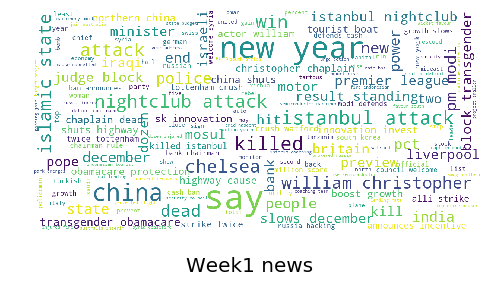

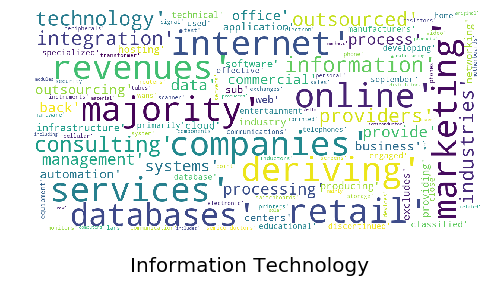

In [39]:
show_wordcloud(text_string, title = "Week1 news")
show_wordcloud(wordnew, title="Information Technology" )

In [45]:

article_hash = {}
directory = "/Users/varsha/GWU_SPRING2019/Topics in Big Data/Project/Code/Similarity/Weekly_News"

files = [f for f in listdir(directory) if isfile(join(directory, f))]

for file in files:
    fileop=open(directory+"/"+file,"r")
    text = fileop.read()
    article_hash[file]  = text
    #print("-----------------------------------")
    #print("file;" , file)
    #print(article_hash[file])

-----------------------------------
file; 29.txt
-----------------------------------
file; 15.txt
-----------------------------------
file; 01.txt
-----------------------------------
file; 00.txt
-----------------------------------
file; 14.txt
-----------------------------------
file; 28.txt
-----------------------------------
file; 02.txt
-----------------------------------
file; 16.txt
-----------------------------------
file; 17.txt
-----------------------------------
file; 03.txt
-----------------------------------
file; 07.txt
-----------------------------------
file; 13.txt
-----------------------------------
file; 12.txt
-----------------------------------
file; 06.txt
-----------------------------------
file; 10.txt
-----------------------------------
file; 04.txt
-----------------------------------
file; 38.txt
-----------------------------------
file; 39.txt
-----------------------------------
file; 05.txt
-----------------------------------
file; 11.txt
--------------------

In [46]:
directory = "/Users/varsha/GWU_SPRING2019/Topics in Big Data/Project/Code/Similarity/keywords_extracted"


keywords_article_hash = {}
files = [f for f in listdir(directory) if isfile(join(directory, f))]

for file in files:
    fileop=open(directory+"/"+file,"r", encoding="utf8", errors='ignore')
    text = fileop.read()
    keywords_article_hash[file]  = text
    #print("-----------------------------------")
    #print("file;" , file)
   # print(keywords_article_hash[file])
    




-----------------------------------
file; dict_Information Technology.txt
-----------------------------------
file; dict_Utilities.txt
-----------------------------------
file; dict_Consumer_Discretionary.txt
-----------------------------------
file; .DS_Store
-----------------------------------
file; dict_Industry.txt
-----------------------------------
file; dict_Materials.txt
-----------------------------------
file; dict_RealEstate.txt
-----------------------------------
file; dict_Consumer_Staples.txt
-----------------------------------
file; dict_Financials.txt
-----------------------------------
file; dict_Communication_Services.txt
-----------------------------------
file; dict_energy.txt
-----------------------------------
file; dict_HealthCare.txt


In [49]:
processed_article_hash ={}  

#Performing various pre processing --stemming, tokenization and removal of stopwords

for key in article_hash.keys():    
     text_of_article = article_hash[key]
     stemmer = PorterStemmer()

     def stem_tokens(tokens, stemmer):
          stemmed = []
          for item in tokens:
             stemmed.append(stemmer.stem(item))
          return stemmed

     def tokenize(text):
          tokens = nltk.word_tokenize(text)
          tokens = [word for word in tokens if word not in stopwords.words('english')]
          stems = stem_tokens(tokens, stemmer)
          return ' '.join(stems)

     intab = string.punctuation
     outtab = "                                "
     trantab = str.maketrans(intab, outtab)
     tokenize(text_of_article)
     print("-----------------------------")
     #print(key)
     #print(tokenize(text_of_article))     
    
     processed_article_hash[key] = tokenize(text_of_article)
     

-----------------------------
29.txt
-----------------------------
15.txt
-----------------------------
01.txt
-----------------------------
00.txt
-----------------------------
14.txt
-----------------------------
28.txt
-----------------------------
02.txt
-----------------------------
16.txt
-----------------------------
17.txt
-----------------------------
03.txt
-----------------------------
07.txt
-----------------------------
13.txt
-----------------------------
12.txt
-----------------------------
06.txt
-----------------------------
10.txt
-----------------------------
04.txt
-----------------------------
38.txt
-----------------------------
39.txt
-----------------------------
05.txt
-----------------------------
11.txt
-----------------------------
49.txt
-----------------------------
48.txt
-----------------------------
43.txt
-----------------------------
42.txt
-----------------------------
40.txt
-----------------------------
41.txt
-----------------------------
45.txt
-

In [50]:
def jaccard_similarity(a, b):
    intersection = float(len(set(a) & set(b)))
    union = float(len(set(a) | set(b)))
    return (intersection/union)




In [60]:

dist =jaccard_similarity( processed_article_hash['08.txt'],keywords_article_hash['dict_Financials.txt'])
if len(processed_article_hash) < 52:
     print("%.2f" % dist ,"", end='')
else:
    print("%.2f" % dist ,"",end ='')
            
    print("\n")
    

0.49 

